In [1]:
import random
import time
import pymongo
import requests
from selenium.webdriver import Chrome, ActionChains
from selenium.webdriver.chrome.options import Options
from lxml import etree
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import font_manager
import random


In [3]:
def getProxy():
    s = requests.session()
    s.keep_alive = False
    url_list = ['http://192.168.2.120:5000']
    url = url_list[0]
    headers = {
        'Connection': 'close',
    }
    proxy = s.get(url, headers=headers, auth=('admin', 'zd123456')).text[0:-6]
    return proxy

In [2]:
def start_driver(url):
    chrome_options = Options()
    # chrome_options.add_argument("--headless")
    ip = '192.168.2.144:16127'
    # chrome_options.add_argument(('--proxy-server=' + ip))
    chrome_options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36')
    
    driver = Chrome(options=chrome_options)
    
    with open('stealth.min.js') as f:
        js = f.read()
    
    driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
      "source": js
    })
    
    # #在网页上加鼠标的移动轨迹显示
    # driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
    #   "source": '''window.onmousemove = function(event){
    #             var nDiv = document.createElement('div')  //创建新的div
    #             var e = event || window.event   //获取事件对象
    #             //设置div的样式(红色小圆点)和位置(鼠标当前位置)
    #             nDiv.style.cssText = "position:absolute; width:5px; height:5px; background-color:red; border-radius:50%"   
    #             nDiv.style.left = e.pageX + "px"
    #             nDiv.style.top = e.pageY + "px"
    #             //把创建好的div添加到body里面
    #             document.body.appendChild(nDiv)
    # 
    #             //延迟定时器实现一秒后删除效果
    #             setTimeout(function(){
    #                 nDiv.remove();
    #             },1000)
    #         }'''
    # })
    
    driver.get(url)
    return driver

In [3]:
def get_yzm(driver):
    html = etree.HTML(driver.page_source)
    slider = html.xpath('//div[@id="dx_captcha_basic_sub-slider_1"]/img/@src')[0]
    # print(slider)
    response = requests.get(slider)
    with open('slider.png','wb') as f:
        f.write(response.content)
    f.close()
    
    ele = driver.find_element_by_id('dx_captcha_basic_bg_1')
    ele.screenshot('yzm.png') 

In [4]:
def run():
    
    # parameter to seperate template area from find temple area
    cropcol = 65
    
    # path2files = '/home/junyi/R/RPA/yolo/c3/'
    target_rgb_raw = cv2.imread('yzm.png')
    target_rgb = target_rgb_raw[:,:cropcol,:]
    template_gray = cv2.imread('slider.png', 0)

    
    # PART1 - find y area where figures are located, in order to crop out unnecessary parts
    
    # target: find green area with mask filter
    target_rgb = target_rgb_raw[:,:cropcol,:]
    hsv = cv2.cvtColor(target_rgb, cv2.COLOR_BGR2HSV)
    lower_green = np.array([30,60,60])
    upper_green = np.array([78,255,255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # target: do erode+dilate in order to delete noise
    
    # first try erode+dilate on 3x3
    kernel = np.ones((3,3),np.uint8)
    maskm = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # if first fail, second try erode+dilate on 1x1
    if np.min(np.where(maskm.sum(1)>0))>=118 : 
        kernel = np.ones((1,1),np.uint8)
        maskm = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # if second fail, do not run any erode+dilate
    if np.min(np.where(maskm.sum(1)>0))>=118 or len(np.where(maskm.sum(1)>0)[0])<=25: 
    #if np.min(np.where(maskm.sum(1)>0))>=118: 
        maskm = mask



    # define y area where figures are located
    index_step = 10
    top_index = np.min(np.where(maskm.sum(1)>0)) - index_step
    bot_index = top_index + index_step + index_step + 40 



    # PART2 - clean template 
    
    ret, template_threshed = cv2.threshold(template_gray, 70, 250, cv2.THRESH_BINARY)
    contour,hier = cv2.findContours(template_threshed,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv2.drawContours(template_threshed,[cnt],0,255,-1)
    template_gray0 = template_gray*(template_threshed/255).astype(np.uint8)
    xvals  = np.where(template_gray0.any(axis=0))
    xvals1 = max(0,np.min(xvals)-5)
    xvals2 = np.max(xvals)+5
    yvals  = np.where(template_gray0.any(axis=1))
    yvals1 = max(0,np.min(yvals)-5)
    yvals2 = np.max(yvals)+5
    template_gray01 = template_gray0[yvals1:yvals2,xvals1:xvals2]

    template_gray2 = np.delete (template_gray01, np.where(~template_gray01.any(axis=1)), axis=0)
    template_gray2 = np.delete (template_gray2, np.where(~template_gray2.any(axis=0)), axis=1)
    template_gray2 =  cv2.resize(template_gray2, (40,40)).astype(np.uint8)
    template_gray1 = template_gray2.copy()
    template_gray2[template_gray2>0]=255
    w, h = template_gray2.shape[::-1]
    edges = cv2.Canny(template_gray2,50,150,apertureSize = 3)

    template_gray01[template_gray01>0]=255
    edges1 = cv2.Canny(template_gray01,50,150,apertureSize = 3)
    edges1 = np.delete (edges1, np.where(~edges1.any(axis=1)), axis=0)
    edges1 = np.delete (edges1, np.where(~edges1.any(axis=0)), axis=1)
    edges1 =  cv2.resize(edges1, (40,40)).astype(np.uint8)
    edges1[edges1>0] = 255


    # PART3 - clean crop out target
    
    # crop out unnecessary parts and apply threshold functions
    target_rgb = target_rgb_raw[top_index:bot_index,cropcol:,:]
    target_gray = cv2.cvtColor(target_rgb, cv2.COLOR_BGR2GRAY)
    ret, threshed0 = cv2.threshold(target_gray, 50, 255, cv2.THRESH_TOZERO)
    ret, threshed0 = cv2.threshold(threshed0, 55, 60, cv2.THRESH_TOZERO)
    thresh = cv2.adaptiveThreshold(threshed0, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 6)
    th3 = cv2.adaptiveThreshold(threshed0, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  cv2.THRESH_BINARY, 11, 11)


    # PART4 - match target contours with template contours
    
    df = pd.DataFrame()
    
    # run 4 models 
    res1 = cv2.matchTemplate(thresh, edges, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res1)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)

    res2 = cv2.matchTemplate(thresh, edges1, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res2)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)

    res2 = cv2.matchTemplate(threshed0, edges, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res2)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)

    res2 = cv2.matchTemplate(threshed0, edges1, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res2)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)

    res2 = cv2.matchTemplate(th3, edges, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res2)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)

    res2 = cv2.matchTemplate(th3, edges1, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res2)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)

    # select top result based on correlation coef and topleft point location
    df.columns = ['coef','x','y']
    df['coef_abs'] = df.coef.abs()
    

    if df.coef_abs.max() >= 4e6:
        df = df[df.coef_abs >= 4e6]   
    if (df.y>0).sum():
        df = df[df.y>0]
    if (df.y>7).sum():
        df = df[df.y>7]
    if (df.x>0).sum():
        df = df[df.x>0]
    if (df.y<18).sum():
        df = df[df.y<18]
    
    df = df.sort_values(by=['coef_abs'], ascending=False)
    top_left = (df.iloc[0,:].values[1:3])
    top_left = tuple(np.int16(top_left))
    distance = top_left[0]
    
    # plot debug
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(target_gray,top_left, bottom_right, 255, 2)
    x = [distance  +(w/2)]
    plt.subplot(211),plt.imshow(template_gray)
    plt.subplot(212),plt.imshow(target_gray),plt.plot(x, 30, '*', linewidth=5000, color='firebrick')
    plt.show() 
    print(df)
    print(distance+cropcol)
    return(distance + 50)

In [5]:
def get_removing(run):
    list_ren1 = [(0, 0), (4, 0), (8, 1), (13, 1), (20, 2), (29, 2), (37, 2), (45, 2), (58, 3), (66, 3), (73, 3), (80, 3), (87, 3), (94, 3), (101, 3), (107, 3), (113, 3), (120, 3), (128, 3), (133, 4), (143, 6), (147, 7), (149, 7), (151, 7), (155, 7), (159, 8), (163, 9), (165, 9), (169, 10), (172, 10), (175, 10), (180, 10), (186, 11), (190, 11), (194, 12), (197, 12), (199, 12), (202, 12), (204, 12), (205, 12), (206, 12), (207, 12), (208, 12), (210, 12), (212, 12), (214, 12), (215, 12), (216, 12), (217, 12), (218, 12), (219, 12), (220, 12), (221, 12), (222, 12), (223, 12), (224, 12), (225, 12), (226, 12), (227, 12), (228, 12), (229, 12)]
    list_ren2 = [(0, 0), (3, 0), (10, 0), (14, 1), (18, 1), (25, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 3), (34, 3), (35, 3), (37, 3), (40, 3), (41, 3), (48, 3), (51, 3), (53, 3), (54, 3), (55, 4), (56, 4), (57, 4), (58, 4), (60, 4), (63, 4), (66, 4), (67, 4), (69, 4), (70, 4), (72, 4), (75, 4), (76, 4), (79, 4), (80, 4), (82, 4), (85, 4), (90, 4), (96, 4), (100, 4), (101, 4), (102, 4), (106, 4), (108, 4), (109, 4), (110, 5), (112, 5), (115, 5), (117, 5), (120, 5), (123, 6), (126, 6), (129, 7), (131, 7), (132, 7), (133, 7), (134, 7), (136, 7), (137, 7), (139, 7), (141, 7), (143, 7), (145, 7), (148, 7), (149, 7), (151, 7), (152, 7), (153, 7), (154, 7), (155, 7), (157, 7), (160, 7), (162, 7), (163, 7), (166, 7), (170, 7), (174, 7), (175, 7), (176, 7), (177, 7), (178, 7), (179, 7), (180, 7), (181, 7), (182, 7), (183, 7), (184, 7), (185, 7), (186, 7), (187, 7), (188, 7), (189, 7), (190, 6), (191, 6), (192, 6)]
    list_ren3 = [(0, 0), (7, 0), (25, 0), (49, 0), (71, 0), (89, 0), (109, 0), (122, 1), (138, 2), (153, 5), (168, 6), (183, 6), (200, 7), (216, 8), (226, 8), (231, 10), (233, 10), (236, 10), (239, 10), (242, 10), (243, 10), (245, 10), (246, 9), (247, 9), (248, 8), (250, 8), (251, 8), (252, 8), (255, 8), (256, 8), (259, 7), (261, 7), (261, 6)]
    list_ren4 = [(0, 0), (2, 0), (3, 0), (5, 0), (6, 0), (8, 0), (9, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (21, 0), (28, 0), (34, 0), (37, 0), (40, 0), (46, 0), (49, 0), (53, 0), (57, 0), (61, 0), (65, 0), (70, 0), (74, 1), (77, 1), (79, 1), (80, 1), (82, 1), (84, 1), (87, 1), (90, 1), (93, 3), (97, 4), (98, 4), (99, 4), (100, 4), (101, 4), (103, 4), (105, 4), (106, 5), (107, 5), (110, 5), (112, 5), (113, 5), (114, 5), (115, 5), (117, 5), (119, 5), (121, 5), (122, 5), (123, 5), (124, 5), (125, 5), (128, 5), (129, 5), (131, 5), (134, 6), (135, 6), (136, 6), (137, 6), (137, 7), (139, 7), (141, 7), (144, 8), (147, 8), (149, 9), (150, 9), (151, 10), (153, 10), (155, 10), (157, 11), (160, 11), (161, 11), (163, 11), (167, 13), (169, 13), (171, 13), (173, 13), (174, 13)]
    list_ren5 = [(0, 0), (1, 0), (2, 0), (3, 0), (5, 1), (9, 3), (14, 3), (20, 4), (30, 4), (35, 4), (38, 6), (40, 6), (43, 6), (47, 7), (51, 7), (53, 7), (56, 7), (62, 7), (67, 7), (74, 7), (83, 7), (86, 7), (90, 7), (93, 7), (96, 7), (99, 7), (102, 7), (105, 7), (109, 7), (112, 7), (118, 7), (123, 7), (130, 7), (133, 8), (134, 8), (137, 8), (139, 9), (141, 9), (143, 10), (145, 10), (147, 10), (149, 10), (157, 10), (160, 10), (164, 10), (168, 10), (170, 10), (171, 10), (173, 10), (174, 10), (176, 10), (177, 10), (179, 10), (178, 10), (177, 10), (176, 10), (175, 10), (174, 10), (173, 10), (172, 10), (171, 10)]
    list_ren = random.choice([list_ren1,list_ren2,list_ren3,list_ren4,list_ren5])
    # list_ren = list_ren5
    q =  run / list_ren[-1][0]
    list_moni = []
    for i in list_ren:
        x = int(i[0] * q)
        y = int(i[1] * q)
        list_moni.append((x, y))
    return list_moni

In [6]:
def move(driver,list_moni):
    btn = driver.find_element_by_id("dx_captcha_basic_slider_1")
    mouse_action = ActionChains(driver).click_and_hold(btn)
    movedx = 0
    movedy = 0 
    for i in list_moni:
        mouse_action.move_by_offset(i[0] - movedx, i[1] - movedy)
        movedx = i[0]
        movedy = i[1]
    time.sleep(0.48)
    # mouse_action.move_by_offset(list_moni[-1][0],list_moni[-1][1])
    mouse_action.release().perform()

In [13]:
forbidden_url = 'https://www.che300.com/partner/result.php?prov=3&city=3&brand=35&series=421&model=22790&registerDate=2012-1&mileAge=18.5&intention=0&partnerId=cheniu&unit=1&sn=c82de048d432f2cc697331413c425d18&sld=sh'
url = 'https://www.che300.com/partner/result.php?prov=9&city=9&brand=9&series=2233&model=22414&registerDate=2017-1&mileAge=8&intention=0&partnerId=ynhcj&unit=1&sn=624e150569cc97df95e6c2de9fcee043&sld=cc'
for i in range(1):
    try:
        driver = start_driver(forbidden_url)
        time.sleep(3)
        for i in range(10):
            try:
                get_yzm(driver)
            except:
                print('代理过慢，验证码未加载出来')
                if '加载失败' in driver.page_source:
                    flash = driver.find_element_by_xpath("//div[@id='dx_captcha_basic_state-box_1']/a")
                    mouse_action = ActionChains(driver).click(flash).perform()
                time.sleep(2)
                continue
            try:
                removing = run()
            except ValueError:
                print('换一张图片再识别')
                flash = driver.find_element_by_id("dx_captcha_basic_btn-refresh_1")
                mouse_action = ActionChains(driver).click(flash).perform()
                time.sleep(1)
                continue
            list_moni = get_removing(removing)
            move(driver, list_moni)
            time.sleep(5)
            if '价格区间分布' in driver.page_source:
                print('成功！！！')
                # driver.close()
                break
        # try:
        #     driver.close()
        # except:
        #     pass
    except:
        # try:
        #     driver.close()
        # except:
        #     pass
        continue
    





代理过慢，验证码未加载出来


In [42]:
url = 'https://www.che300.com/forbidden/partner_index?pd=08889f905c847e59832b60b5599c991d&r_u=%2Fpartner%2Fresult.php%3Fprov%3D9%26city%3D9%26brand%3D9%26series%3D2233%26model%3D22414%26registerDate%3D2017-1%26mileAge%3D8%26intention%3D0%26partnerId%3Dynhcj%26unit%3D1%26sn%3D624e150569cc97df95e6c2de9fcee043%26sld%3Dcc%2F'
driver = start_driver(url)

In [43]:
get_yzm(driver)

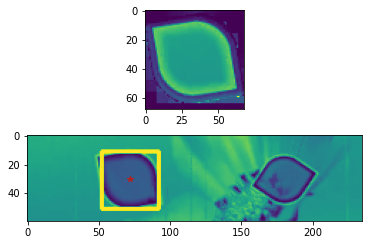

         coef     x     y   coef_abs
2  -7168681.5  52.0  11.0  7168681.5
10 -7144258.0  52.0  12.0  7144258.0
8  -5038992.0  53.0  12.0  5038992.0
0  -4525741.0  53.0  12.0  4525741.0
117


In [44]:
removing = run()

In [45]:
list_moni = get_removing(removing)
move(driver, list_moni)

In [38]:
list_moni = [(0, 0),
 (162, 8)]

In [41]:
'id="dx_captcha_clickword_hits_2"' in driver.page_source

False